In [85]:
import pandas as pd
import numpy as np
from keras import Sequential
from keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking, GRU
import numpy as np
import keras
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
import datetime
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
import tensorflow as tf
import tensorflow_hub as hub
from keras import initializers as initializers, regularizers, constraints
from keras import backend as K
from keras import layers
from tensorflow import keras
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
from numpy import load
from numpy import asarray
from numpy import save
import pandas as pd
import matplotlib.pyplot as plt


np.random.seed(1337)# setting the random seed value

In [2]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
path_dataset = "drive/My Drive/dataset.csv" # path to dataset

In [4]:
dataset = pd.read_csv(path_dataset)

In [5]:
# path to transformer generated chunk embeddings eg. XLNet etc.
path_transformer_chunk_embeddings_train = 'drive/My Drive/XLNet/XLNet_train.npy' 
path_transformer_chunk_embeddings_dev = 'drive/My Drive/XLNet/XLNet_dev.npy'
path_transformer_chunk_embeddings_test = 'drive/My Drive/XLNet/XLNet_test.npy'

In [6]:
# loading the chunk embeddings
x_train0 = load(path_transformer_chunk_embeddings_train, allow_pickle = True)
x_dev0 = load(path_transformer_chunk_embeddings_dev, allow_pickle= True)
x_test0 = load(path_transformer_chunk_embeddings_test, allow_pickle= True)

In [7]:
# loading the corresponding label for each case in dataset
dev = dataset.loc[dataset['split'] == 'dev'] 
train = dataset.loc[dataset['split'] == 'train'] 
test = dataset.loc[dataset['split'] == 'test'] 

y_train0 = []
for i in range(train.shape[0]):
    y_train0.append(train.loc[i,'label'])  
    
y_dev0 = []
for i in range(dev.shape[0]):
    y_dev0.append(dev.loc[i+32305,'label'])

y_test0 = []
for i in range(test.shape[0]):
    y_test0.append(test.loc[i+33299,'label'])

In [86]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

In [89]:
class AttentionLayer(Layer):
    """
    Hierarchial Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    Theano backend
    """
    def __init__(self,attention_dim=200,return_coefficients=False,**kwargs):
        # Initializer 
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self.trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def _get_attention_weights(self, X):
        
        u_tw = K.tanh(K.dot(X, self.W))
        tw_stimulus = K.dot(u_tw, self.u)

        # Remove the last axis an apply softmax to the stimulus to
        # get a probability.
        tw_stimulus = K.squeeze(tw_stimulus, -1)
        tw_stimulus = K.exp(tw_stimulus)
        

        tw_stimulus /= K.cast(K.sum(tw_stimulus, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        att_weights = K.expand_dims(tw_stimulus)
        return att_weights

    def call(self, hit, mask=None):
        att_weights = self._get_attention_weights(hit)
  
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]


In [90]:
# Input layer to convert into required tensor shape
text_input = Input(shape=(None,768,), dtype='float32', name='text')
# Masking layer to mask the padded values
l_mask = layers.Masking(mask_value=-99.)(text_input) #2 sent_encoder
# After masking we encoded the vector using 2 bidirectional GRU's
encoded_text = layers.Bidirectional(GRU(100,return_sequences=True))(l_mask) 
encoded_text1 = layers.Bidirectional(GRU(100,return_sequences=True))(encoded_text)
# Then we add the Attention Layer which we created above
sent_att,sent_coeffs, = AttentionLayer(200,return_coefficients=True,name='sent_attention')(encoded_text1)
# Add a dropout layer 
sent_drop = Dropout(0.5,name='sent_dropout')(sent_att)
# Added a dense layer after encoding
out1 = layers.Dense(30, activation='relu')(sent_drop) 
# And we add a sigmoid classifier on top
out = layers.Dense(1, activation='sigmoid')(out1)
model = Model(text_input,out)

model.summary()


tracking <tf.Variable 'sent_attention_2/W:0' shape=(200, 200) dtype=float32> W
tracking <tf.Variable 'sent_attention_2/b:0' shape=(200,) dtype=float32> b
tracking <tf.Variable 'sent_attention_2/u:0' shape=(200, 1) dtype=float32> u
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            (None, None, 768)         0         
_________________________________________________________________
masking_3 (Masking)          (None, None, 768)         0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 200)         521400    
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 200)         180600    
_________________________________________________________________
sent_attention (AttentionLay [(None, 200), (None, 200, 40400     
__________________________

In [12]:
num_sequences = len(x_train0)
batch_size = 32
batches_per_epoch =  int(num_sequences/batch_size)
num_features= 768
def train_generator(): # function to generate batches of corresponding batch size
    x_list= x_train0
    y_list =  y_train0
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(x_train0[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            # padding the vectors with respect to the maximum sequence of each batch and not the whole training data
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [13]:
num_sequences_val = len(x_dev0)
batch_size_val = 32
batches_per_epoch_val = int(num_sequences_val/batch_size_val)
num_features= 768
def val_generator(): # Similar function to generate validation batches
    x_list= x_dev0
    y_list =  y_dev0
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(x_dev0[:(b + 1) * batch_size_val][-batch_size_val:], key=len))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            # padding the vectors with respect to the maximum sequence of each batch and not the whole validation data
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [14]:
# compiling the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [15]:
# Setting the callback and training the model
from keras.callbacks import ReduceLROnPlateau
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=2, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

model.fit_generator(train_generator(), steps_per_epoch=batches_per_epoch, epochs=2,
                    validation_data=val_generator(), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )


Epoch 1/2
1009/1009 [==============================] - 267s 264ms/step - loss: 0.4890 - acc: 0.7575 - val_loss: 0.5314 - val_acc: 0.7772
Epoch 2/2
1009/1009 [==============================] - 270s 267ms/step - loss: 0.4719 - acc: 0.7685 - val_loss: 0.4947 - val_acc: 0.7923


In [17]:
num_features= 768
def test_generator(): # function to generate batches of corresponding batch size
    x_list= x_test0
    y_list =  y_test0
    # Generate batches
    while True:
        for b in range(batches_per_epoch_test): 
            if(b == batches_per_epoch_test-1): # An extra if else statement just to manage the last batch as it's size might not be equal to batch size 
              longest_index = num_sequences_test - 1
              timesteps = len(max(x_test0[:longest_index + 1][-batch_size_test:], key=len))
              x_train = np.full((longest_index - b*batch_size_test, timesteps, num_features), -99.)
              y_train = np.zeros((longest_index - b*batch_size_test,  1))
              for i in range(longest_index - b*batch_size_test):
                  li = b * batch_size_test + i
                  x_train[i, 0:len(x_list[li]), :] = x_list[li]
                  y_train[i] = y_list[li]
            else:
                longest_index = (b + 1) * batch_size_test - 1
                timesteps = len(max(x_test0[:(b + 1) * batch_size_test][-batch_size_test:], key=len))
                x_train = np.full((batch_size_test, timesteps, num_features), -99.)
                y_train = np.zeros((batch_size_test,  1))
                # padding the vectors with respect to the maximum sequence of each batch and not the whole test data
                for i in range(batch_size_test):
                    li = b * batch_size_test + i
                    x_train[i, 0:len(x_list[li]), :] = x_list[li]
                    y_train[i] = y_list[li]
            yield x_train, y_train

In [18]:
num_sequences_test = len(x_test0)
batch_size_test = 32
batches_per_epoch_test = int(num_sequences_test/batch_size_test) + 1
num_features= 768
# evaluating on the test data
model.evaluate_generator(test_generator(), steps= batches_per_epoch_test)

[0.5585814118385315, 0.7823218703269958]

In [19]:
# defining a function which calculates various metrics such as micro and macro precision, accuracy and f1
def metrics_calculator(preds, test_labels):
    cm = confusion_matrix(test_labels, preds)
    TP = []
    FP = []
    FN = []
    for i in range(0,2):
        summ = 0
        for j in range(0,2):
            if(i!=j):
                summ=summ+cm[i][j]

        FN.append(summ)
    for i in range(0,2):
        summ = 0
        for j in range(0,2):
            if(i!=j):
                summ=summ+cm[j][i]

        FP.append(summ)
    for i in range(0,2):
        TP.append(cm[i][i])
    precision = []
    recall = []
    for i in range(0,2):
        precision.append(TP[i]/(TP[i] + FP[i]))
        recall.append(TP[i]/(TP[i] + FN[i]))

    macro_precision = sum(precision)/2
    macro_recall = sum(recall)/2
    micro_precision = sum(TP)/(sum(TP) + sum(FP))
    micro_recall = sum(TP)/(sum(TP) + sum(FN))
    micro_f1 = (2*micro_precision*micro_recall)/(micro_precision + micro_recall)
    macro_f1 = (2*macro_precision*macro_recall)/(macro_precision + macro_recall)
    return macro_precision, macro_recall, macro_f1, micro_precision, micro_recall, micro_f1

In [20]:
# getting the predicted labels on the test data
preds = model.predict_generator(test_generator(), steps= batches_per_epoch_test)
y_pred = preds > 0.5

# Calculating all metrics on test data predicted label
print(metrics_calculator(y_pred, y_test0[:-1]))

(0.7843687234135859, 0.7821514041301529, 0.783258494527811, 0.7823218997361477, 0.7823218997361477, 0.7823218997361477)


In [21]:
# getting the predicted labels on the dev data
preds = model.predict_generator(val_generator(), steps= batches_per_epoch_val)
y_pred_dev = preds > 0.5

# Calculating all metrics on dev data predicted label
print(metrics_calculator(y_pred_dev, y_dev0[:-2]))

(0.7925718005044342, 0.7923387096774193, 0.792455237950737, 0.7923387096774194, 0.7923387096774194, 0.7923387096774194)


In [22]:
# saving the trained model
model.save('BIGRU_Attention_XLNet.h5')  # creates a HDF5 file 'BIGRU_Attention_XLNet.h5'

In [24]:
# getting the self attention layer from the trained model and creating a new model with that layer to get attention weights
att_layer = model.get_layer('sent_attention')
prev_tensor = att_layer.input

dummy_layer = Lambda(lambda x: att_layer._get_attention_weights(x))(prev_tensor)
model2 = Model(text_input, dummy_layer)
model2.summary()

prev_tensor Tensor("bidirectional_2/concat:0", shape=(None, None, 200), dtype=float32)
dummy_layer Tensor("lambda_1/ExpandDims:0", shape=(None, None, 1), dtype=float32)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            (None, None, 768)         0         
_________________________________________________________________
masking_1 (Masking)          (None, None, 768)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 200)         521400    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 200)         180600    
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 1)           0         
Total params: 702,000
Trainable params: 702,000
Non-trainable params: 0
________________

In [62]:
# splitting test data depending on chunk length
x_chunks = []*25
for i in range(25):
  x_chunks.append([])
for i in range(len(x_test0)):
  x_chunks[len(x_test0[i]) - 1].append(x_test0[i])

In [66]:
# getting attention weights for each chunk and finding the mean over all data for a particular chunk length
wt_vector = []*25
wt_total = []*25

for chunk_length in range(25):
  wt_vector.append([])
  wt_total.append(0)
  for i in range(len(x_chunks[chunk_length])):
     curr = x_chunks[chunk_length][i]
     curr = curr.reshape((1, len(curr), 768))
     wt_vector[chunk_length].append(model2.predict(curr))
     wt_total[chunk_length] +=wt_vector[chunk_length][i]
  wt_total[chunk_length] /= len(wt_vector[chunk_length])
  wt_total[chunk_length] = np.squeeze(wt_total[chunk_length], axis = 0)
  wt_total[chunk_length] = np.squeeze(wt_total[chunk_length], axis = 1)

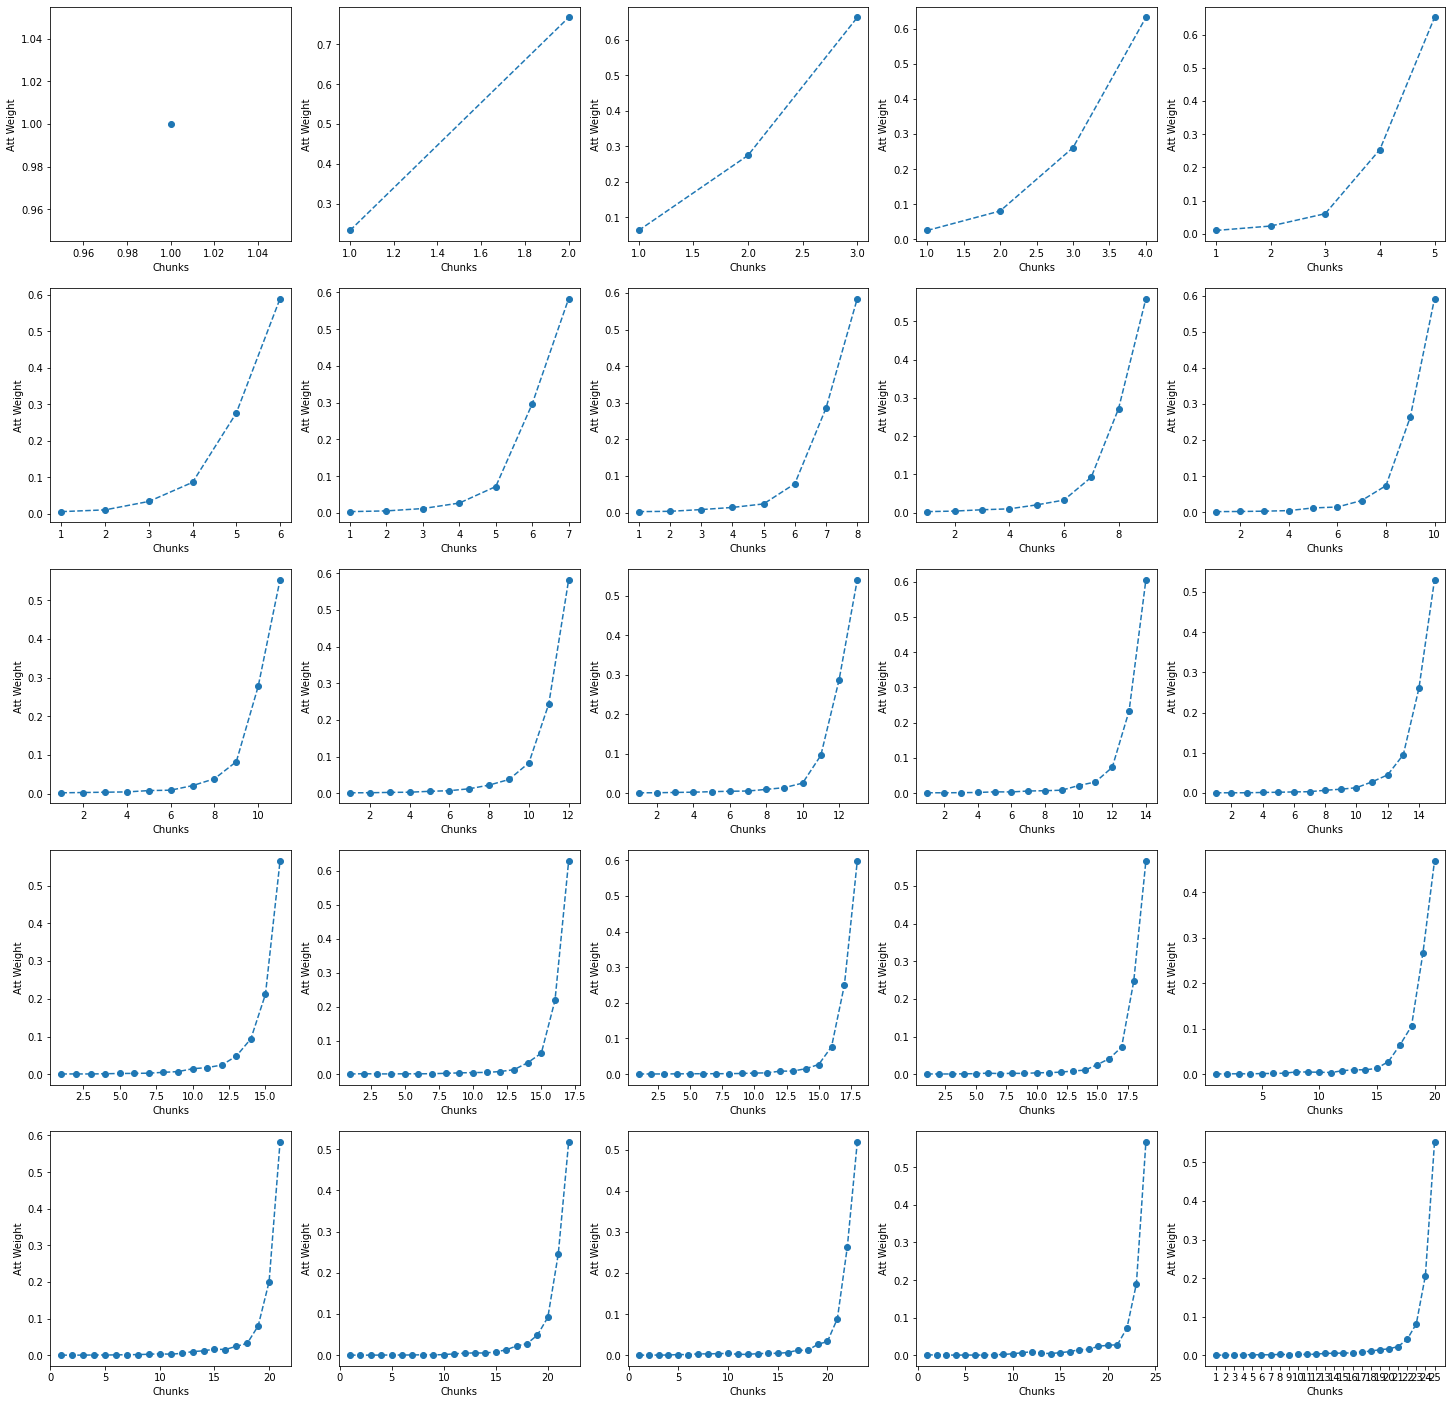

In [83]:
# plotting subplots for each chunk length( x axis: chunk size, y axis: mean attention weight)
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
num = [1]

for chunk_len in range(25):
  plt.xticks(y)
  y = num
  axs[(int)(chunk_len/5), chunk_len%5].plot(y, wt_total[chunk_len], marker = 'o', linestyle = 'dashed')
  num.append(chunk_len + 2)

for ax in axs.flat:
    ax.set(xlabel='Chunks', ylabel='Att Weight')
plt.show()


In [84]:
# saving the mean attention weights in numpy file for future referanc
data = []
for i in range(25):
  data.append(wt_total[i])

# save to npy file
save('att_wt_of_XLNet_gru.npy', data)
